In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/roco-dataset/all_data/validation/radiologyvaldata.csv
/kaggle/input/roco-dataset/all_data/validation/radiology/captions.txt
/kaggle/input/roco-dataset/all_data/validation/radiology/cuis.txt
/kaggle/input/roco-dataset/all_data/validation/radiology/keywords.txt
/kaggle/input/roco-dataset/all_data/validation/radiology/licences.txt
/kaggle/input/roco-dataset/all_data/validation/radiology/valdata.csv
/kaggle/input/roco-dataset/all_data/validation/radiology/dlinks.txt
/kaggle/input/roco-dataset/all_data/validation/radiology/semtypes.txt
/kaggle/input/roco-dataset/all_data/validation/radiology/images/PMC5045996_CRIC2016-3589214.003.jpg
/kaggle/input/roco-dataset/all_data/validation/radiology/images/PMC4327617_1678-7757-jaos-17-01-0066-gf01a.jpg
/kaggle/input/roco-dataset/all_data/validation/radiology/images/PMC2687662_kjim-22-279-g001.jpg
/kaggle/input/roco-dataset/all_data/validation/radiology/images/PMC3902575_IJCCM-17-378-g002.jpg
/kaggle/input/roco-dataset/all_data/validatio

In [2]:
import os

def count_images_in_directory(base_path):
    counts = {}
    for root, dirs, files in os.walk(base_path):
        category = os.path.basename(root)
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]
        counts[category] = len(image_files)
    return counts

dataset_path = "/kaggle/input/roco-dataset/all_data/test"  
image_counts = count_images_in_directory(dataset_path)

for category, count in image_counts.items():
    if count > 0:  
        print(f"{category}: {count} images")


images: 610 images


In [2]:
import pandas as pd
import shutil
import os

csv_path = "/kaggle/input/roco-dataset/all_data/test/radiologytestdata.csv"
captions_df = pd.read_csv(csv_path)
def sample_subset_from_radiology(dataframe, sample_size, source_dir, target_dir):
    # Filter the dataframe to include only radiology images
    dataframe['path'] = dataframe['name'].apply(lambda x: os.path.join(source_dir,"images", x))
    filtered_df = dataframe[dataframe['path'].apply(os.path.exists)]
    print(len(filtered_df))
    # Check if enough samples exist
    if len(filtered_df) < sample_size:
        print(f"Requested {sample_size} samples, but only {len(filtered_df)} images available.")
        sample_size = len(filtered_df)

    # Sample the subset
    sampled = filtered_df.sample(n=sample_size, random_state=42)
    os.makedirs(target_dir, exist_ok=True)
    image_path = os.path.join(source_dir,"images")
    os.makedirs(image_path, exist_ok=True)
    for _, row in sampled.iterrows():
        image_name = row['name']
        caption = row['caption']
        # Copy image to the target directory
        src_path = os.path.join(source_dir,"images", image_name)
        dest_path = os.path.join(target_dir, "images",image_name)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
            print(f"Copied {image_name}. Caption: {caption}")

    # Save sampled captions to a new CSV file
    sampled.drop(columns=['path'], inplace=True)
    sampled.to_csv(os.path.join(target_dir, "sampled_captions.csv"), index=False)

sample_size = 1000  
source_directory = "/kaggle/input/roco-dataset/all_data/test/radiology"  
target_directory = "/kaggle/working/sampled_dataset_radiology_10000"  

sample_subset_from_radiology(captions_df, sample_size, source_directory, target_directory)


8176
Copied PMC2831869_1749-799X-5-9-1.jpg. Caption:  Pertrochanteric fracture treated with IMHS nail.

Copied PMC4707006_12917_2016_634_Fig4_HTML.jpg. Caption:  Laterolateral radiograph of the skull of a 6-year-old female sheep. Characters indicate measured angles (turquoise) ([8], figure reproduced with the permission of the publisher)

Copied PMC4900367_ACA-19-379-g002.jpg. Caption:  Computed tomography chest before whole lung lavage

Copied PMC4895068_gr2.jpg. Caption:  21-year-old woman with metastatic carcinoid tumor. Sagittal right upper quadrant sonogram shows numerous hypoechoic hepatic masses.

Copied PMC4644744_kjr-16-1240-g002.jpg. Caption:  Opening of distal end of choledochus to 3rd segment of duodenum.On this MRCP image, small periampullary diverticulum is depicted (black arrow), and also in this patient, major papilla variationally opens to 3rd section of duodenum (white arrow). Major papilla is in horizontal, i.e., 3rd, segment at rate of 25%. MRCP = magnetic resonance

In [3]:
!pip install torch torchvision ftfy regex
!pip install git+https://github.com/openai/CLIP.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-m4olf8mx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-m4olf8mx
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=b14b21674d9fb3e2025523daa7aa2ae8b73ba232e10639809d00b45014e91475
  Stored in directory: /tmp/pip-ephem-wheel-cache-767dzrjx/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 132MiB/s]
<ipython-input-4-ba2cd1d3c81a>:44: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
<ipython-input-4-ba2cd1d3c81a>:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
<ipython-input-4-ba2cd1d3c81a>:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch [1/10], Train Loss: 9.3824, Validation Loss: 3.0546
Epoch [2/10], Train Loss: 2.2293, Validation Loss: 2.0241
Epoch [3/10], Train Loss: 1.4351, Validation Loss: 1.8857
Epoch [4/10], Train Loss: 0.9675, Validation Loss: 2.2081
Epoch [5/10], Train Loss: 0.7240, Validation Loss: 2.4972
Epoch [6/10], Train Loss: 0.5057, Validation Loss: 3.0529
Epoch [7/10], Train Loss: 0.4902, Validation Loss: 2.3952
Epoch [8/10], Train Loss: 0.4274, Validation Loss: 2.9373
Epoch [9/10], Train Loss: 0.3395, Validation Loss: 3.8350
Epoch [10/10], Train Loss: 0.3697, Validation Loss: 3.0832


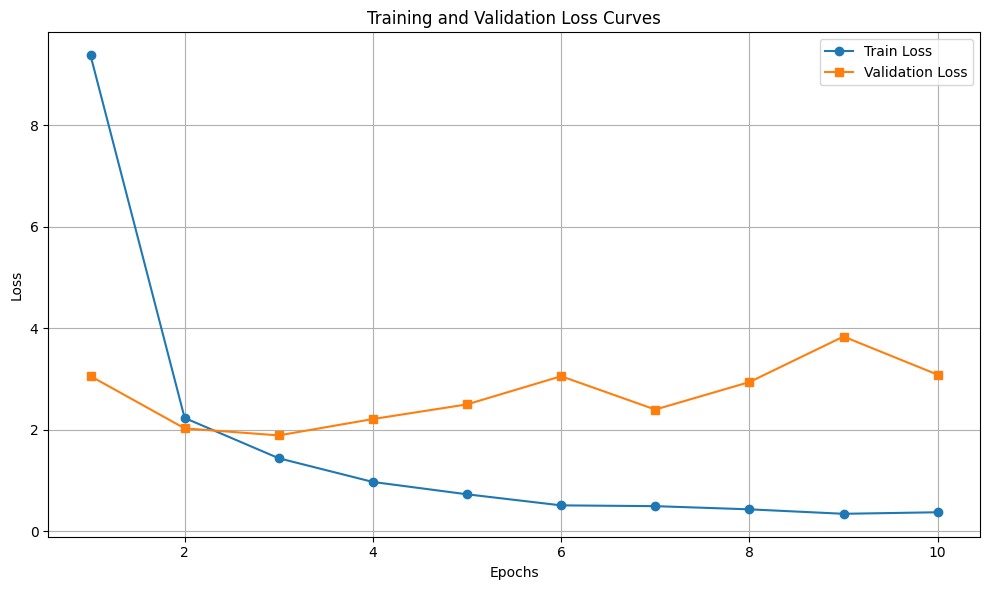

In [4]:
import os
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import clip
import torch.nn.functional as F
import torch.cuda.amp as amp
from torch.nn.utils import clip_grad_norm_
from matplotlib import pyplot as plt
# Parameters
target_dir = "/kaggle/working/sampled_dataset_radiology_10000"
csv_path = os.path.join(target_dir, "sampled_captions.csv")
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 16
learning_rate = 1e-5
num_epochs = 10

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, "images", self.data.iloc[idx, 1])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        caption = self.data.iloc[idx, 2][:75]
        return image, caption

# Load CLIP model
model, preprocess = clip.load("ViT-B/32", jit=False, device=device)
model = model.float()

# Initialize optimizer and scaler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = amp.GradScaler()

# Create dataset and dataloader
dataset = CustomDataset(csv_path, target_dir, transform=preprocess)

# Split dataset into train, validation, and test sets (80%, 10%, 10%)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create dataloaders for each dataset
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def train_epoch():
    model.train()
    total_loss = 0
    for images, captions in train_dataloader:
        images = images.to(device).float()
        text_inputs = torch.cat([clip.tokenize(caption) for caption in captions]).to(device)
        
        optimizer.zero_grad()
        
        with amp.autocast():
            logits_per_image, logits_per_text = model(images, text_inputs)
            
            temperature = 0.07
            logits_per_image = logits_per_image / temperature
            logits_per_text = logits_per_text / temperature
            
            labels = torch.arange(len(images), device=device)
            loss_img = F.cross_entropy(logits_per_image, labels)
            loss_txt = F.cross_entropy(logits_per_text, labels)
            loss = (loss_img + loss_txt) / 2
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()

    return total_loss / len(train_dataloader)

def validate():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions in val_dataloader:
            images = images.to(device).float()
            text_inputs = torch.cat([clip.tokenize(caption) for caption in captions]).to(device)
            
            with amp.autocast():
                logits_per_image, logits_per_text = model(images, text_inputs)
                temperature = 0.07
                logits_per_image = logits_per_image / temperature
                logits_per_text = logits_per_text / temperature
                
                labels = torch.arange(len(images), device=device)
                loss_img = F.cross_entropy(logits_per_image, labels)
                loss_txt = F.cross_entropy(logits_per_text, labels)
                loss = (loss_img + loss_txt) / 2
                
            total_loss += loss.item()

    return total_loss / len(val_dataloader)

def train():
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loss = train_epoch()
        val_loss = validate()
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    torch.save(model.state_dict(), "fine_tuned_clip_model.pth")

train()


In [7]:
model.load_state_dict(torch.load("fine_tuned_clip_model.pth", map_location=device))


<ipython-input-7-22254674df0b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fine_tuned_clip_model.pth", map_location=device))


<All keys matched successfully>

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FusionNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FusionNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, output_dim)
    
    def forward(self, img_embeds, text_embeds):
        combined = torch.cat([img_embeds, text_embeds], dim=1)
        combined = F.relu(self.fc1(combined))
        combined = self.fc2(combined)
        return F.normalize(combined, p=2, dim=1)

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        
    def forward(self, img_embeds, text_embeds):
        """
        Compute contrastive loss for a batch of image-text pairs
        
        Args:
            img_embeds: Image embeddings [batch_size, embed_dim]
            text_embeds: Text embeddings [batch_size, embed_dim]
        """
        # Get batch size
        batch_size = img_embeds.shape[0]
        
        # Compute similarity matrix
        logits = torch.matmul(img_embeds, text_embeds.T) / self.temperature
        
        # Labels are the diagonal elements (positive pairs)
        labels = torch.arange(batch_size, device=img_embeds.device)
        
        # Compute loss in both directions (image->text and text->image)
        loss_i2t = F.cross_entropy(logits, labels)
        loss_t2i = F.cross_entropy(logits.T, labels)
        
        # Total loss is the average of both directions
        total_loss = (loss_i2t + loss_t2i) / 2
        return total_loss

def create_batches(image_embeddings, text_embeddings, batch_size):
    """Create batches from embeddings"""
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(image_embeddings).float(),
        torch.tensor(text_embeddings).float()
    )
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training function
def train_fusion_network(image_embeddings, text_embeddings, num_epochs=10, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    fusion_net = FusionNetwork(input_dim=1024, output_dim=512).to(device)
    optimizer = torch.optim.Adam(fusion_net.parameters(), lr=1e-4)
    criterion = ContrastiveLoss(temperature=0.07)
    
    train_loader = create_batches(image_embeddings, text_embeddings, batch_size)
    
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        
        for img_embeds, txt_embeds in train_loader:
            img_embeds = img_embeds.to(device)
            txt_embeds = txt_embeds.to(device)
            
            fused_img = fusion_net(img_embeds, txt_embeds)
            fused_txt = fusion_net(txt_embeds, img_embeds)
            
            loss = criterion(fused_img, fused_txt)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    
    return fusion_net

fusion_net = train_fusion_network(image_embeddings, text_embeddings)

Epoch 1/10, Average Loss: 2.8832
Epoch 2/10, Average Loss: 2.7587
Epoch 3/10, Average Loss: 2.5029
Epoch 4/10, Average Loss: 1.9810
Epoch 5/10, Average Loss: 1.3849
Epoch 6/10, Average Loss: 0.9096
Epoch 7/10, Average Loss: 0.5495
Epoch 8/10, Average Loss: 0.4059
Epoch 9/10, Average Loss: 0.3332
Epoch 10/10, Average Loss: 0.2203


<ipython-input-31-53d4ef1d93b4>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(image_embeddings).float(),
<ipython-input-31-53d4ef1d93b4>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(text_embeddings).float()


In [25]:
def get_fused_embeddings(fusion_net, img_embeds, txt_embeds, device, batch_size=32):
    """
    Get fused embeddings for a set of image and text embeddings
    """
    fusion_net.eval()  
    fused_embeddings = []
    
    if isinstance(img_embeds, np.ndarray):
        img_embeds = torch.tensor(img_embeds).float()
    if isinstance(txt_embeds, np.ndarray):
        txt_embeds = torch.tensor(txt_embeds).float()
    
    with torch.no_grad():
        for i in range(0, len(img_embeds), batch_size):
            batch_img = img_embeds[i:i+batch_size].to(device)
            batch_txt = txt_embeds[i:i+batch_size].to(device)
            
            # Get fused embeddings
            fused = fusion_net(batch_img, batch_txt)
            fused_embeddings.append(fused.cpu())
    
    return torch.cat(fused_embeddings, dim=0).numpy()
    
fused_embeddings = get_fused_embeddings(
    fusion_net,
    image_embeddings,
    text_embeddings,
    device
)

In [10]:
#Load the saved fine-tuned model weights
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
model.load_state_dict(torch.load("fine_tuned_clip_model.pth", map_location=device))
from sklearn.metrics.pairwise import cosine_similarity
def get_image_embeddings(test_loader):
    model.eval()
    image_embeddings = []
    
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device).float()
            image_embeds = model.encode_image(images)
            image_embeddings.append(image_embeds.cpu().numpy())
    
    image_embeddings = np.vstack(image_embeddings)
    return image_embeddings
import torch.nn as nn
import torch.nn.functional as F

class FusionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FusionHead, self).__init__()
        # Fully connected layer to reduce dimensionality
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, img_embeds, text_embeds):
        device = img_embeds.device
        text_embeds = text_embeds.to(device)
        # Concatenate image and text embeddings along the feature dimension
        combined_embeds = torch.cat([img_embeds, text_embeds], dim=1)
        # Pass through the FC layer
        combined_embeds = self.fc(combined_embeds)
        # Normalize the output
        return F.normalize(combined_embeds, p=2, dim=1)

# Function to get text embeddings from the test loader
def get_text_embeddings(test_loader):
    model.eval()
    text_embeddings = []
    
    with torch.no_grad():
        for _, captions in test_loader:
            # Tokenize the captions and move them to the correct device
            text_inputs = torch.cat([clip.tokenize(caption) for caption in captions]).to(device)
            
            # Pass the text through the CLIP model to get embeddings
            text_embeds = model.encode_text(text_inputs)
            text_embeddings.append(text_embeds.cpu().numpy())
    
    text_embeddings = np.vstack(text_embeddings)  # Stack the embeddings into a single array
    return text_embeddings


# Function to fuse image and text embeddings using the FusionHead
def fuse_embeddings(img_embeds, text_embeds, fusion_head):
    img_embeds = torch.tensor(img_embeds).to(device)
    text_embeds = torch.tensor(text_embeds).to(device)
    fused_embeds = fusion_head(img_embeds, text_embeds)
    return fused_embeds

# Example usage:

# Initialize the fusion head (input_dim should be the sum of image and text embedding dimensions, output_dim is the desired output size)
fusion_head = FusionHead(input_dim=512 + 512, output_dim=512)  # Assuming both image and text embeddings are 512-dimensional

# Assume test_dataloader is your DataLoader and captions are provided
image_embeddings = get_image_embeddings(test_dataloader)
text_embeddings = get_text_embeddings(test_dataloader)

# Fuse the embeddings
#fused_embeddings = fuse_embeddings(image_embeddings, text_embeddings, fusion_head)




<ipython-input-10-5b7b3d69a8b9>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fine_tuned_clip_model.pth", map_location=device))


98


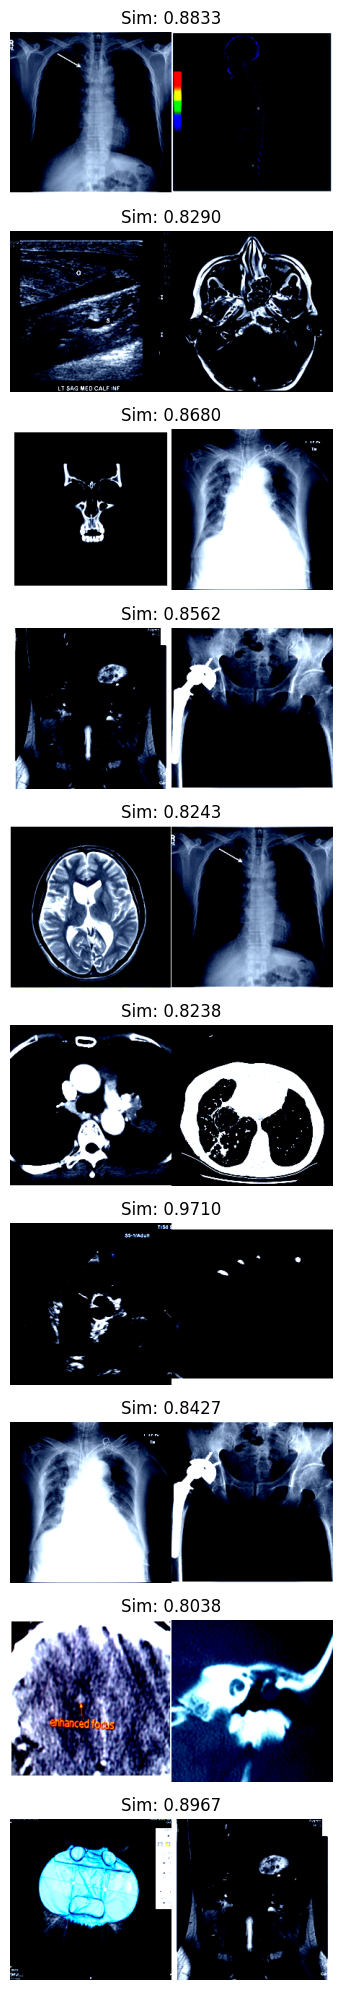

In [36]:

import random
from sklearn.metrics.pairwise import cosine_similarity
def linear_rescale(x, old_min=0.7, old_max=1.0, new_min=0.5, new_max=1.0):
    """
    Linearly rescales values from one range to another.
    
    Parameters:
        x: Input value or array
        old_min: Minimum value in original range
        old_max: Maximum value in original range
        new_min: Minimum value in target range
        new_max: Maximum value in target range
    """
    return new_min + (x - old_min) * (new_max - new_min) / (old_max - old_min)
def display_similar_pairs(image_embeddings, threshold=0.9, num_pairs=5):
    # Compute cosine similarity between all image pairs
    similarity = cosine_similarity(image_embeddings, image_embeddings)
    #similarity = linear_rescale(similarity)
    # Mask out the diagonal (image with itself) by setting those values to -1
    np.fill_diagonal(similarity, -1)
    # Find indices where similarity is above threshold
    similar_pairs = np.argwhere(similarity > threshold)
    print(len(similar_pairs))
    if len(similar_pairs) > num_pairs:
        # Randomly select num_pairs pairs
        selected_pairs = random.sample(list(similar_pairs), num_pairs)
        # Plot the pairs with similarity
        fig, axes = plt.subplots(num_pairs,1, figsize=(15, num_pairs*2))
        
        for i, (idx1, idx2) in enumerate(selected_pairs):
            # Get the images corresponding to the pair
            img1 = dataset[idx1][0].permute(1, 2, 0).cpu().numpy()  
            img2 = dataset[idx2][0].permute(1, 2, 0).cpu().numpy()  
            similarity_score = similarity[idx1, idx2]

            axes[i].imshow(np.concatenate([np.array(img1), np.array(img2)], axis=1))
            axes[i].set_title(f"Sim: {similarity_score:.4f}")
            axes[i].axis('off')
    
        plt.tight_layout()
        plt.show()

display_similar_pairs(fused_embeddings, threshold=0.8, num_pairs=10)


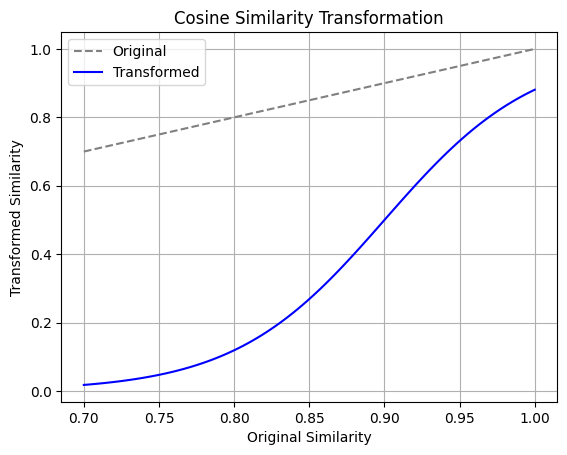